In [1]:
#
# Google Drive에서 파일을 불러올 수 있도록 함
#

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
import skimage
import seaborn as sns
from google.colab.patches import cv2_imshow

from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import make_classification
import pandas as pd
from sklearn.metrics import plot_confusion_matrix

#
# load_image_files는 정해진 path에서 폴더를 찾음.
# 이 경우, normal과 defect 2개의 폴더 내에 이미지 파일들이 들어가 있음.
# 이 Image file을 모두 들고와서 64 x 64 pixel로 줄임.
# 폴더(categori)와 이미지파일(data)을 반환
#

def load_image_files(container_path, dimension=(64, 64)):
    """
    Load image files with categories as subfolder names 
    which performs like scikit-learn sample dataset
    
    Parameters
    ----------
    container_path : string or unicode
        Path to the main folder holding one subfolder per category
    dimension : tuple
        size to which image are adjusted to
        
    Returns
    -------
    Bunch
    """
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    images = []
    flat_data = []
    target = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            img = skimage.io.imread(file)
            img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
            flat_data.append(img_resized.flatten()) 
            images.append(img_resized)
            target.append(i)
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)

    return Bunch(data=flat_data,
                 target=target,
                 target_names=categories,
                 images=images,
                 DESCR=descr)

In [3]:
image_dataset = load_image_files("/gdrive/My Drive/PythonVision/Cosmetic/")
print('data : ', image_dataset.data)
print('target : ', image_dataset.target)

data :  [[0.62829733 0.62745098 0.63614047 ... 0.54509804 0.53333333 0.53224188]
 [0.57254902 0.56470588 0.56862745 ... 0.56078431 0.5591299  0.5473652 ]
 [0.58823529 0.57647059 0.58823529 ... 0.53912377 0.54117647 0.5372549 ]
 ...
 [0.67058824 0.68235294 0.67785501 ... 0.63921569 0.64705882 0.64313725]
 [0.68627451 0.69411765 0.68235294 ... 0.63137255 0.63921569 0.62745098]
 [0.68627451 0.69411765 0.68235294 ... 0.63529412 0.64313725 0.63137255]]
target :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

In [4]:
#
# train_test_split을 이용, test data와 train data를 알아서 나눔.
# test_size, random_state를 바꾸어가며 확인하면 ok
#

X_train, X_test, y_train, y_test = train_test_split(
    image_dataset.data, image_dataset.target, test_size=0.3,random_state=10)

print('X_train : ' , X_train)
print('X_test : ', X_test)
print('y_train : ' , y_train)
print('y_test : ', y_test)

X_train :  [[0.72156863 0.7372549  0.71764706 ... 0.69019608 0.69803922 0.69019608]
 [0.69019608 0.69803922 0.68627451 ... 0.64313725 0.65098039 0.63921569]
 [0.68627451 0.69411765 0.68235294 ... 0.63223039 0.64007353 0.63615196]
 ...
 [0.73333333 0.74117647 0.72941176 ... 0.69019608 0.69837623 0.69019608]
 [0.73333333 0.74117647 0.72941176 ... 0.66666667 0.67843137 0.67058824]
 [0.68235294 0.69019608 0.67843137 ... 0.63921569 0.65490196 0.63921569]]
X_test :  [[0.72941176 0.7372549  0.7254902  ... 0.69803922 0.70588235 0.69019608]
 [0.74117647 0.74901961 0.72941176 ... 0.68235294 0.69019608 0.68235294]
 [0.73333333 0.74117647 0.72941176 ... 0.66666667 0.67506127 0.66666667]
 ...
 [0.69019608 0.69411765 0.68627451 ... 0.63529412 0.64313725 0.63137255]
 [0.74117647 0.74901961 0.7372549  ... 0.68627451 0.69411765 0.68235294]
 [0.55294118 0.55686275 0.55294118 ... 0.63921569 0.63921569 0.63921569]]
y_train :  [0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1
 1 1 

In [5]:
#
# param_grid에서 kernel의 형태를 정함.
# 두 가지의 형태 중에서 무엇이 더 뛰어난지는 알아서 결정함.
# 1번 형태와 2번 형태를 넣었을 때 2번이 더 좋다면, 결과는 2번만으로 반환.
#
# 아래에서 C는 초평면(kernel의 형태)에서 부터 얼마나 sample이 멀어져있는가를 의미.
# 이 값에 따라 정확도가 달라짐
#
# kernel의 경우, 여러 sample을 나눌 때에 선형으로 나눌 것인지, 비선형으로 나눌것인지,
# 비선형중에서는 어떤 형태로 나눌것인지 선택이 가능. 여기서는 rbf를 선택해보았음
#
# Cost가 되는 parameter는 kernel이 linear인 경우에는 C만 존재
# kernel이 rbf인 경우에는 C값과 gamma값이 됨.
#
param_grid = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001, 0.00001], 'kernel': ['rbf']}]

#
# SVC 객체 선언 
#
svc = svm.SVC()

#
# GridSearchCV 이용 -> 그리드를 사용한 복수 하이퍼 파라미터 최적화
# Wrapper 성격의 Class. -> 자동으로 복수개의 내부 모형을 생성, 이를 모두 실행시켜 최적 parameter를 찾아줌
# (물론 parameter들은 정해진 것들 중에서 결정하게 됨)
# 여기서 내부 test를 거쳐 가장 성능이 좋은 상태를 결정하게 됨.
#
# mean test score에서 성적이 가장 좋은 아이를 best parameter로 결정.
#

clf = GridSearchCV(svc, param_grid)
gs = clf.fit(X_train, y_train)
print('Result for params : ' ,gs.cv_results_["params"])
print('Mean test score : ', gs.cv_results_["mean_test_score"])
print('best score : ', gs.best_score_)
print('best params : ', gs.best_params_)

df = pd.DataFrame(np.vstack([gs.cv_results_["mean_test_score"], gs.cv_results_["params"]]).T, 
                  columns = ["mean_score", "params"])

df.sort_values("mean_score", ascending=False).reset_index(drop=True)

Result for params :  [{'C': 0.001, 'kernel': 'linear'}, {'C': 0.01, 'kernel': 'linear'}, {'C': 0.1, 'kernel': 'linear'}, {'C': 1, 'kernel': 'linear'}, {'C': 10, 'kernel': 'linear'}, {'C': 100, 'kernel': 'linear'}, {'C': 1000, 'kernel': 'linear'}, {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}, {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}, {'C': 0.001, 'gamma': 1e-05, 'kernel': 'rbf'}, {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}, {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}, {'C': 0.01, 'gamma': 1e-05, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}, {'C': 1, 'gamma': 1e-05, 'kernel': 'rbf'}, {'C': 10, 'gamma': 0.01, 'ker

,mean_score,params
0,0.995238,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}"
1,0.995238,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}"
2,0.995238,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}"
3,0.975958,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}"
4,0.97108,"{'C': 0.001, 'kernel': 'linear'}"
5,0.97108,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}"
6,0.970964,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}"
7,0.970964,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}"
8,0.961324,"{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}"
9,0.961324,"{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}"


X_test :  [[0.72941176 0.7372549  0.7254902  ... 0.69803922 0.70588235 0.69019608]
 [0.74117647 0.74901961 0.72941176 ... 0.68235294 0.69019608 0.68235294]
 [0.73333333 0.74117647 0.72941176 ... 0.66666667 0.67506127 0.66666667]
 ...
 [0.69019608 0.69411765 0.68627451 ... 0.63529412 0.64313725 0.63137255]
 [0.74117647 0.74901961 0.7372549  ... 0.68627451 0.69411765 0.68235294]
 [0.55294118 0.55686275 0.55294118 ... 0.63921569 0.63921569 0.63921569]]
y_pred :  [0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1
 1 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 1
 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 1]
x_min :  0.39803921568627454  x_max :  0.8411764705882353
y_min :  0.40481004901960793  y_max :  0.8643573835784316
xx :  [[0.39803922 0.44803922 0.49803922 0.54803922 0.59803922 0.64803922
  0.69803922 0.74803922 0.79803922]
 [0.39803922 0.44803922 0.49803922 0.54803922 0.59803922 0.64803922
  0.69803922 0.74803922 0.79803922]
 [0.39803922 0.4480392

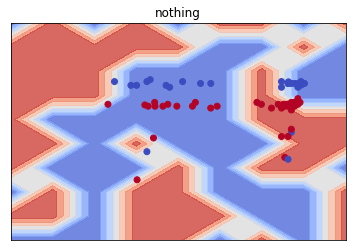

In [9]:
y_pred = clf.predict(X_test)
print('X_test : ', X_test)
print('y_pred : ', y_pred)

#
# 아래는 visualization을 통해 어떤 방식으로 구간을 나눌 수 있었는지에 대해
# 확인하려 하였으나, 마땅한 방법이 없음.
# 64x64의 mesh grid를 그리고 그 위에 y_pred를 그려보았으나
# 어떤 방식으로 판단된지는 확인이 불가능
#

x_min, x_max = X_train[:,0].min() - 0.1, X_train[:,0].max() + 0.1
y_min, y_max = X_train[0,:].min() - 0.1, X_train[0,:].max() + 0.1

h = 0.05

xx,yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

print('x_min : ', x_min, ' x_max : ', x_max)
print('y_min : ', y_min, ' y_max : ', y_max)
print('xx : ', xx)
print('yy : ', yy)
'''
print('gs value : ', gs)
print('gs.estimator value : ', gs.best_estimator_)
'''
print('xx shape : ', xx.shape)
print('yy shape : ', yy.shape)

plt.figure()

Z = y_pred.reshape(xx.shape)
plt.contourf(xx , yy , Z , cmap = plt.cm.coolwarm, alpha = 0.8)

print('len X_train[:,0] : ', len(X_train[:,0][:64]))
print('len X_train[0,:] : ', len(X_train[0,:][:64]))
print('Z.shape : ', Z.shape)

print('Z : ', Z)

plt.scatter(X_train[0][:64], X_train[:,0][:64], c = y_train[:64], cmap=plt.cm.coolwarm)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('nothing')

plt.show()

In [10]:
print("Classification report for - \n{}:\n{}\n".format(
    clf, metrics.classification_report(y_test, y_pred, target_names=['normal', 'defect'])))

Classification report for - 
GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['linear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0):
              precision    recall  f1-score   support

      normal       1.0

Confusion matrix, without normalization
[[44  0]
 [ 0 46]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


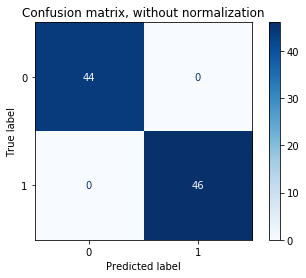

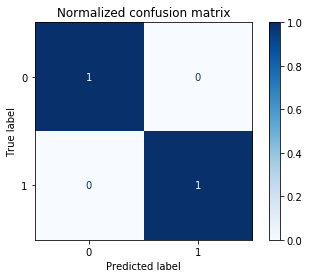

In [12]:
#
# 위 결과를 바탕으로 Confusion Matrix를 그림
#

from sklearn.metrics import plot_confusion_matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gs,
                                 X_test,
                                 y_pred,
                                 cmap=plt.cm.Blues,
                                 normalize = normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()